In [1]:
import math
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelBinarizer
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.python.framework import ops
from tf_utils import random_mini_batches, convert_to_one_hot
%matplotlib inline

In [2]:
def load_data(file):
    data_orig = pd.read_csv(file).to_numpy()
    m = data_orig.shape[0]
    X = data_orig[:, 1:]
    Y = data_orig[:, 0].reshape(m, 1)
    return m, X, Y

In [3]:
m_train, X_train_orig, Y_train_orig = load_data('DataSet/train.csv')
m_test, X_test_orig, Y_test_orig = load_data('DataSet/test.csv')

X_train = X_train_orig.T
Y_train_temp = Y_train_orig.T

X_test = X_test_orig.T
Y_test_temp = Y_test_orig.T
Y_train_temp.shape

X_train = X_train / 255
X_test = X_test / 255

In [4]:
lb=LabelBinarizer()
Y_train=lb.fit_transform(Y_train_temp.T).T
Y_test=lb.fit_transform(Y_test_temp.T).T

In [5]:
def create_placeholders(n_x, n_y):
    """
    Creates the placeholders for the tensorflow session.

    Arguments:
    n_x -- scalar, size of an image vector (num_px * num_px = 64 * 64 * 3 = 12288)
    n_y -- scalar, number of classes (from 0 to 5, so -> 6)

    Returns:
    X -- placeholder for the data input, of shape [n_x, None] and dtype "tf.float32"
    Y -- placeholder for the input labels, of shape [n_y, None] and dtype "tf.float32"

    """
    X = tf.placeholder(tf.float32, [n_x, None], name = "X")
    Y = tf.placeholder(tf.float32, [n_y, None], name = "Y")
    keep_prob = tf.placeholder(tf.float32, name = "keep_prob")
    
    return X, Y, keep_prob

In [6]:
def initialize_parameters(n):
    """
    Initializes parameters to build a neural network with tensorflow. The shapes are:
                        W1 : [25, 784]
                        b1 : [25, 1]
                        W2 : [12, 25]
                        b2 : [12, 1]
                        W3 : [6, 12]
                        b3 : [6, 1]
    
    Returns:
    parameters -- a dictionary of tensors containing W1, b1, W2, b2, W3, b3
    """
    
    tf.set_random_seed(1)                  
        
    W1 = tf.get_variable("W1", [n[1],n[0]], initializer = tf.contrib.layers.xavier_initializer(seed = 1))
    b1 = tf.get_variable("b1", [n[1],1], initializer = tf.zeros_initializer())
    W2 = tf.get_variable("W2", [n[2],n[1]], initializer = tf.contrib.layers.xavier_initializer(seed = 1))
    b2 = tf.get_variable("b2", [n[2],1], initializer = tf.zeros_initializer())
    W3 = tf.get_variable("W3", [n[3],n[2]], initializer = tf.contrib.layers.xavier_initializer(seed = 1))
    b3 = tf.get_variable("b3", [n[3],1], initializer = tf.zeros_initializer())

    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2,
                  "W3": W3,
                  "b3": b3}
    
    return parameters

In [7]:
def forward_propagation(X, parameters, keep_prob):
    """
    Implements the forward propagation for the model: LINEAR -> RELU -> LINEAR -> RELU -> LINEAR -> SOFTMAX
    
    Arguments:
    X -- input dataset placeholder, of shape (input size, number of examples)
    parameters -- python dictionary containing your parameters "W1", "b1", "W2", "b2", "W3", "b3"
                  the shapes are given in initialize_parameters

    Returns:
    Z3 -- the output of the last LINEAR unit
    """
    
    # Retrieve the parameters from the dictionary "parameters" 
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    W3 = parameters['W3']
    b3 = parameters['b3']
    
                                                                     # Numpy Equivalents:
    Z1 = tf.add(tf.matmul(W1, X), b1)                                              # Z1 = np.dot(W1, X) + b1
    A1 = tf.nn.relu(Z1)                                              # A1 = relu(Z1)
    A1 = tf.nn.dropout(A1, keep_prob)
    
    Z2 = tf.add(tf.matmul(W2, A1), b2)                                              # Z2 = np.dot(W2, A1) + b2
    A2 = tf.nn.relu(Z2)                                              # A2 = relu(Z2)
    A2 = tf.nn.dropout(A2, keep_prob)
    
    Z3 = tf.add(tf.matmul(W3, A2), b3)                                               # Z3 = np.dot(W3, A2) + b3
    
    return Z3

In [8]:
def compute_cost(Z5, Y):
    """
    Computes the cost
    
    Arguments:
    Z3 -- output of forward propagation (output of the last LINEAR unit), of shape (6, number of examples)
    Y -- "true" labels vector placeholder, same shape as Z3
    
    Returns:
    cost - Tensor of the cost function
    """
    
    # to fit the tensorflow requirement for tf.nn.softmax_cross_entropy_with_logits(...,...)
    logits = tf.transpose(Z5)
    labels = tf.transpose(Y)
    
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = logits, labels = labels))
    
    return cost

In [12]:
def model(X_train, Y_train, X_test, Y_test, learning_rate = 0.0001,
          num_epochs = 1500, minibatch_size = 32, print_cost = True):
    """
    Implements a three-layer tensorflow neural network: LINEAR->RELU->LINEAR->RELU->LINEAR->SOFTMAX.
    
    Arguments:
    X_train -- training set, of shape (input size = 12288, number of training examples = 1080)
    Y_train -- test set, of shape (output size = 6, number of training examples = 1080)
    X_test -- training set, of shape (input size = 12288, number of training examples = 120)
    Y_test -- test set, of shape (output size = 6, number of test examples = 120)
    learning_rate -- learning rate of the optimization
    num_epochs -- number of epochs of the optimization loop
    minibatch_size -- size of a minibatch
    print_cost -- True to print the cost every 100 epochs
    
    Returns:
    parameters -- parameters learnt by the model. They can then be used to predict.
    """
    
    ops.reset_default_graph()                         # to be able to rerun the model without overwriting tf variables
    tf.set_random_seed(1)                             # to keep consistent results
    seed = 3                                          # to keep consistent results
    (n_x, m) = X_train.shape                          # (n_x: input size, m : number of examples in the train set)
    n_y = Y_train.shape[0]                            # n_y : output size
    costs = []                                        # To keep track of the cost
    
    # Create Placeholders of shape (n_x, n_y)
    X, Y, keep_prob = create_placeholders(n_x, n_y)

    # Initialize parameters
    parameters = initialize_parameters([784, 100, 50, 24])
    
    # Forward propagation: Build the forward propagation in the tensorflow graph
    Z5 = forward_propagation(X, parameters, keep_prob)
    
    # Cost function: Add cost function to tensorflow graph
    cost = compute_cost(Z5, Y)
    
    # Backpropagation: Define the tensorflow optimizer. Use an AdamOptimizer.
    optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(cost)
    
    # Initialize all the variables
    init = tf.global_variables_initializer()

    # Start the session to compute the tensorflow graph
    with tf.Session() as sess:
        
        # Run the initialization
        sess.run(init)
        
        # Do the training loop
        for epoch in range(num_epochs):

            epoch_cost = 0.                       # Defines a cost related to an epoch
            num_minibatches = int(m / minibatch_size) # number of minibatches of size minibatch_size in the train set
            seed = seed + 1
            minibatches = random_mini_batches(X_train, Y_train, minibatch_size, seed)

            for minibatch in minibatches:

                # Select a minibatch
                (minibatch_X, minibatch_Y) = minibatch
                
                # IMPORTANT: The line that runs the graph on a minibatch.
                # Run the session to execute the "optimizer" and the "cost", the feedict should contain a minibatch for (X,Y).
                _ , minibatch_cost = sess.run([optimizer, cost], feed_dict={X: minibatch_X, Y: minibatch_Y, keep_prob: 0.9})
                
                epoch_cost += minibatch_cost / minibatch_size

            # Print the cost every epoch
            if print_cost == True and epoch % 100 == 0:
                print ("Cost after epoch %i: %f" % (epoch, epoch_cost))
            if print_cost == True and epoch % 5 == 0:
                costs.append(epoch_cost)
                
        # plot the cost
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations (per fives)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()

        # lets save the parameters in a variable
        parameters = sess.run(parameters)
        print ("Parameters have been trained!")

        # Calculate the correct predictions
        correct_prediction = tf.equal(tf.argmax(Z5), tf.argmax(Y))

        # Calculate accuracy on the test set
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))

        print ("Train Accuracy:", accuracy.eval({X: X_train, Y: Y_train, keep_prob : 0.9}))
        print ("Test Accuracy:", accuracy.eval({X: X_test, Y: Y_test, keep_prob : 0.9}))
        
        return parameters

Cost after epoch 0: 78.379646
Cost after epoch 100: 1.000391
Cost after epoch 200: 0.418898
Cost after epoch 300: 0.294280
Cost after epoch 400: 0.217951
Cost after epoch 500: 0.195561
Cost after epoch 600: 0.226561
Cost after epoch 700: 0.206467
Cost after epoch 800: 0.218208
Cost after epoch 900: 0.139289
Cost after epoch 1000: 0.217251
Cost after epoch 1100: 0.141911
Cost after epoch 1200: 0.133482
Cost after epoch 1300: 0.161141
Cost after epoch 1400: 0.120989


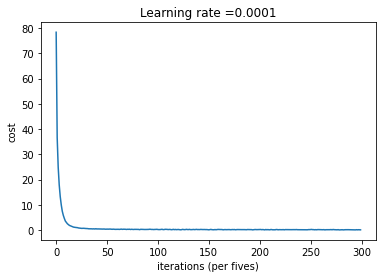

Parameters have been trained!
Train Accuracy: 0.9993808
Test Accuracy: 0.76324594


In [13]:
parameters = model(X_train, Y_train, X_test, Y_test)

In [14]:
np.save('parameters.npy', parameters)

In [15]:
parameters

{'W1': array([[-0.03195445,  0.00518917, -0.01543758, ...,  0.01670314,
          0.15759231,  0.18108812],
        [-0.05551144, -0.05133739, -0.02450057, ..., -0.02878512,
         -0.05367352, -0.34507835],
        [ 0.04384154,  0.02249078, -0.05442654, ..., -0.00845249,
          0.06488973,  0.00853053],
        ...,
        [ 0.17363438,  0.03973291,  0.11797088, ...,  0.11350948,
          0.0811932 ,  0.02822086],
        [ 0.21800263,  0.07782574, -0.02110706, ...,  0.15778042,
          0.2367778 ,  0.13337848],
        [ 0.04785786, -0.08117151,  0.03986374, ..., -0.00531927,
         -0.01957184,  0.07677765]], dtype=float32),
 'b1': array([[-0.17679721],
        [ 0.271812  ],
        [-0.16254812],
        [ 0.09600624],
        [ 0.07354228],
        [-0.04033677],
        [ 0.05657156],
        [-0.135567  ],
        [-0.00148177],
        [-0.03205901],
        [-0.00086464],
        [-0.00262136],
        [-0.19422697],
        [-0.21823268],
        [-0.00102722],
 

In [ ]:
read_dictionary = np.load('parameters.npy',allow_pickle='TRUE').item()
print(read_dictionary) # displays "world"